# Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt



## Reproducibility  
You are setting seeds for reproducibility. Normally, training a neural network contains randomness. So to remove randomness, we set SEED as 42 everywhere.

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**CUDA** device is an NVIDIA GPU that supports CUDA (Compute Unified Device Architecture).  
PyTorch can use CUDA to run tensor operations much faster than on CPU, especially for deep learning.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data Preparation


In [4]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip



--2025-12-02 20:04:14--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T20%3A43%3A48Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T19%3A43%3A26Z&ske=2025-12-02T20%3A43%3A48Z&sks=b&skv=2018-11-09&sig=ddUMUMovNZE07LXRT4t3DlPvg%2F47RDJJ8JuoXP6vBug%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDcwNzY1NSwibmJmIjoxNzY0NzA1ODU1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

## Load Image

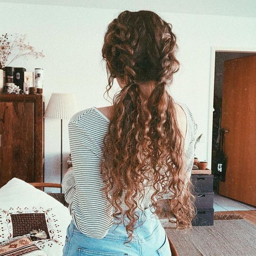

In [5]:
path = '/content/data/train/curly'
name = '2a6d1e3e1c692ca898e3d3a75fd5043b4.jpg'
fullname = f'{path}/{name}'
img = Image.open(fullname)
img.resize((256, 256))



## Custom Dataset Class  
Create a PyTorch Dataset to load images:

In [6]:
class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



## Simple Preprocessing for input

In [7]:
# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean, std=std
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
       mean=mean, std=std
    )
])

## Create DataLoaders

In [8]:
from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir='./data/train/',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='./data/test/',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

## Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are specialized neural networks for processing grid-like data such as images.

Key Components:

1. Convolutional Layer: Extracts features using filters
   - Applies filters (e.g., 3×3, 5×5) to detect patterns
   - Creates feature maps (one per filter)
   - Detects edges, textures, shapes

2. ReLU Activation: Introduces non-linearity
   - `f(x) = max(0, x)`
   - Sets negative values to 0
   - Helps network learn complex patterns

3. Pooling Layer: Down-samples feature maps
   - Reduces spatial dimensions
   - Max pooling: takes maximum value in a region
   - Makes features more robust to small translations

4. Fully Connected (Dense) Layer: Final classification
   - Flattens 2D feature maps to 1D vector
   - Connects to output classes

CNN Workflow:
```
Input Image → Conv + ReLU → Pooling → Conv + ReLU → Pooling → Flatten → Dense → Output
```

## Build the Model
Develop the model with following structure:

* The shape for input should be `(3, 200, 200)` (channels first format in PyTorch)
* Next, create a convolutional layer (`nn.Conv2d`):
    * Use 32 filters (output channels)
    * Kernel size should be `(3, 3)` (that's the size of the filter), padding = 0, stride = 1
    * Use `'relu'` as activation
* Reduce the size of the feature map with max pooling (`nn.MaxPool2d`)
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using `flatten` or `view`
* Next, add a `nn.Linear` layer with 64 neurons and `'relu'` activation
* Finally, create the `nn.Linear` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `torch.optim.SGD` with the following parameters:

* `torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)`


In [9]:
class HairClassifier(nn.Module):
    def __init__(self, num_classes=1):

        super().__init__()

        # Convolution layer
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
        )

        # Activation
        self.activation = nn.ReLU()

        # Max pooling (2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute flatten size
        with torch.no_grad():
            input = torch.zeros(1, 3, 200, 200)
            output = self.pool(self.activation(self.conv(input)))
            self.flatten_dim = output.numel()

        # Connected layer
        self.linear = nn.Linear(self.flatten_dim,64)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):

        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        x = self.activation(x)
        x = self.output(x)
        return x


model = HairClassifier().cuda()
criterion = nn.BCEWithLogitsLoss()

In [10]:
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------


In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


In [12]:
def make_model(learning_rate=0.002):
    model = HairClassifier(num_classes=1)
    model.to(device)

    optimizer = torch.optim.SGD(
                    model.parameters(),
                    lr=learning_rate,
                    momentum=0.8
                )
    return model, optimizer

## Train the Model

In [13]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
  history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
          predicted = (torch.sigmoid(outputs) > 0.5).float()
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_epoch_loss = running_loss / len(train_dataset)
      train_epoch_acc = correct_train / total_train
      history['train_loss'].append(train_epoch_loss)
      history['train_acc'].append(train_epoch_acc)

      model.eval()
      val_running_loss = 0.0
      correct_val = 0
      total_val = 0
      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              labels = labels.float().unsqueeze(1)

              outputs = model(images)
              loss = criterion(outputs, labels)

              val_running_loss += loss.item() * images.size(0)
              predicted = (torch.sigmoid(outputs) > 0.5).float()
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_epoch_loss = val_running_loss / len(val_dataset)
      val_epoch_acc = correct_val / total_val
      history['val_loss'].append(val_epoch_loss)
      history['val_acc'].append(val_epoch_acc)

      print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}, "
            f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
  return model, history

The line `optimizer.zero_grad()` is crucial in the training loop.

In PyTorch, gradients are accumulated by default. This means that if you don't zero the gradients before calculating the gradients for the current batch, the gradients from the previous batch will be added to the gradients of the current batch. This would lead to incorrect updates to your model's parameters.

By calling `optimizer.zero_grad()`, you clear out the old gradients, ensuring that the gradients calculated during the `loss.backward()` call are only based on the current batch of data. This is essential for the optimizer to take the correct step during `optimizer.step()`.

`model.train()` and `model.eval()` are needed to manage the behavior of certain layers during training and evaluation.

`model.train()` sets the model to training mode. In training mode, layers like Dropout and BatchNorm behave differently. Dropout layers are active (randomly dropping neurons), and BatchNorm layers update their running statistics (mean and variance) based on the current batch.

`model.eval()` sets the model to evaluation mode. In evaluation mode, Dropout layers are inactive (they pass through all neurons), and BatchNorm layers use their accumulated running statistics instead of the current batch statistics. This ensures consistent behavior during inference and prevents randomness from affecting the evaluation results.

In [14]:
lr = 0.002
num_epochs = 10
model, optimizer = make_model(learning_rate=lr)
model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/10, Train Loss: 0.6679, Train Acc: 0.6230, Val Loss: 0.6749, Val Acc: 0.6617
Epoch 2/10, Train Loss: 0.5356, Train Acc: 0.7228, Val Loss: 0.7888, Val Acc: 0.5672
Epoch 3/10, Train Loss: 0.5513, Train Acc: 0.6979, Val Loss: 0.6553, Val Acc: 0.6418
Epoch 4/10, Train Loss: 0.4598, Train Acc: 0.7878, Val Loss: 0.6579, Val Acc: 0.6318
Epoch 5/10, Train Loss: 0.4137, Train Acc: 0.8102, Val Loss: 0.7789, Val Acc: 0.6567
Epoch 6/10, Train Loss: 0.4719, Train Acc: 0.7940, Val Loss: 0.5974, Val Acc: 0.7114
Epoch 7/10, Train Loss: 0.3054, Train Acc: 0.8714, Val Loss: 1.2037, Val Acc: 0.5522
Epoch 8/10, Train Loss: 0.5269, Train Acc: 0.7703, Val Loss: 1.2012, Val Acc: 0.5323
Epoch 9/10, Train Loss: 0.5205, Train Acc: 0.7790, Val Loss: 0.8830, Val Acc: 0.6020
Epoch 10/10, Train Loss: 0.3818, Train Acc: 0.8327, Val Loss: 0.6110, Val Acc: 0.7164


In [15]:
print("Median of training accuracy for all the epochs ", np.median(history['train_acc']) )

Median of training accuracy for all the epochs  0.7833957553058677


In [16]:
print("Standard deviation of training loss for all the epochs ",np.std(history['train_loss']))

Standard deviation of training loss for all the epochs  0.0960134326264123


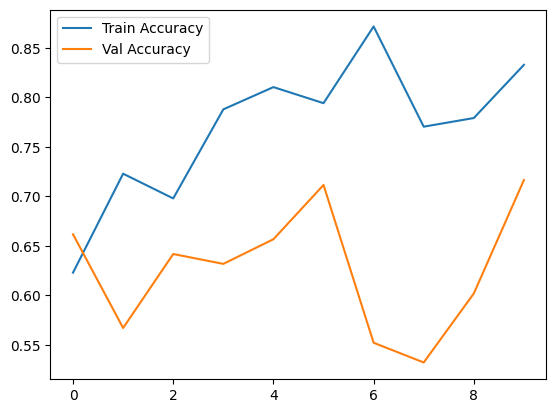

In [17]:
plt.plot(history['train_acc'], label="Train Accuracy")
plt.plot(history['val_acc'], label="Val Accuracy")
plt.legend()
plt.show()

## Tuning the learning rate

In [18]:
learning_rates = [0.0001, 0.001]
num_epochs = 10
scores = {}
for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')

    model, optimizer = make_model(learning_rate=lr)
    model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)
    scores[lr] = history




=== Learning Rate: 0.0001 ===
Epoch 1/10, Train Loss: 0.6423, Train Acc: 0.6255, Val Loss: 0.6116, Val Acc: 0.6219
Epoch 2/10, Train Loss: 0.5786, Train Acc: 0.6991, Val Loss: 0.6092, Val Acc: 0.6368
Epoch 3/10, Train Loss: 0.5367, Train Acc: 0.7216, Val Loss: 0.7001, Val Acc: 0.6219
Epoch 4/10, Train Loss: 0.5281, Train Acc: 0.7391, Val Loss: 0.6180, Val Acc: 0.6169
Epoch 5/10, Train Loss: 0.4867, Train Acc: 0.7466, Val Loss: 0.6160, Val Acc: 0.6219
Epoch 6/10, Train Loss: 0.4760, Train Acc: 0.7553, Val Loss: 0.6248, Val Acc: 0.6567
Epoch 7/10, Train Loss: 0.4513, Train Acc: 0.7878, Val Loss: 0.6012, Val Acc: 0.6517
Epoch 8/10, Train Loss: 0.4328, Train Acc: 0.8165, Val Loss: 0.6115, Val Acc: 0.6667
Epoch 9/10, Train Loss: 0.4188, Train Acc: 0.8140, Val Loss: 0.6186, Val Acc: 0.6517
Epoch 10/10, Train Loss: 0.4022, Train Acc: 0.8290, Val Loss: 0.5953, Val Acc: 0.6716

=== Learning Rate: 0.001 ===
Epoch 1/10, Train Loss: 0.6243, Train Acc: 0.6442, Val Loss: 0.6571, Val Acc: 0.6119
Epo

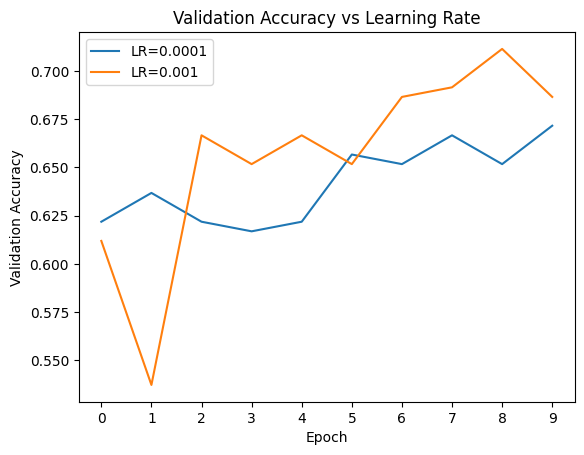

In [19]:
for lr, hist in scores.items():
    plt.plot(hist['val_acc'], label=f"LR={lr}")

plt.xticks(np.arange(10))
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Learning Rate")
plt.legend()
plt.show()

Learning rate of 0.002 is better compared to 0.0001 and 0.001

## Model Checkpoint

In [20]:
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
  best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy
  num_epochs = 10
  history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
          predicted = (torch.sigmoid(outputs) > 0.5).float()
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_epoch_loss = running_loss / len(train_dataset)
      train_epoch_acc = correct_train / total_train
      history['train_loss'].append(train_epoch_loss)
      history['train_acc'].append(train_epoch_acc)

      model.eval()
      val_running_loss = 0.0
      correct_val = 0
      total_val = 0
      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              labels = labels.float().unsqueeze(1)

              outputs = model(images)
              loss = criterion(outputs, labels)

              val_running_loss += loss.item() * images.size(0)
              predicted = (torch.sigmoid(outputs) > 0.5).float()
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_epoch_loss = val_running_loss / len(val_dataset)
      val_epoch_acc = correct_val / total_val
      history['val_loss'].append(val_epoch_loss)
      history['val_acc'].append(val_epoch_acc)

      print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}, "
            f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
      if val_epoch_acc > best_val_accuracy:
        best_val_accuracy = val_epoch_acc
        checkpoint_path = f'cnn_{epoch+1:02d}_{val_epoch_acc:.3f}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')
  return model, history

In [21]:
lr = 0.002
num_epochs = 10
model, optimizer = make_model(learning_rate=lr)
model, history = train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/10, Train Loss: 0.6358, Train Acc: 0.6567, Val Loss: 0.7828, Val Acc: 0.5572
Checkpoint saved: cnn_01_0.557.pth
Epoch 2/10, Train Loss: 0.5750, Train Acc: 0.6966, Val Loss: 0.6131, Val Acc: 0.6368
Checkpoint saved: cnn_02_0.637.pth
Epoch 3/10, Train Loss: 0.4923, Train Acc: 0.7553, Val Loss: 0.7048, Val Acc: 0.6269
Epoch 4/10, Train Loss: 0.5331, Train Acc: 0.7266, Val Loss: 0.6917, Val Acc: 0.6766
Checkpoint saved: cnn_04_0.677.pth
Epoch 5/10, Train Loss: 0.4383, Train Acc: 0.7978, Val Loss: 0.6228, Val Acc: 0.6866
Checkpoint saved: cnn_05_0.687.pth
Epoch 6/10, Train Loss: 0.3784, Train Acc: 0.8202, Val Loss: 1.6914, Val Acc: 0.5224
Epoch 7/10, Train Loss: 0.5588, Train Acc: 0.7341, Val Loss: 0.6750, Val Acc: 0.6617
Epoch 8/10, Train Loss: 0.3822, Train Acc: 0.8240, Val Loss: 0.7217, Val Acc: 0.6368
Epoch 9/10, Train Loss: 0.3416, Train Acc: 0.8414, Val Loss: 0.6735, Val Acc: 0.6766
Epoch 10/10, Train Loss: 0.2353, Train Acc: 0.9076, Val Loss: 0.6604, Val Acc: 0.7015
Checkpoin

**Data Augmentation**  
We'll generate more data using data augmentations.

Add the following augmentations to your training data generator:
```python
transforms.RandomRotation(50),
transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
transforms.RandomHorizontalFlip(),
```

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=mean, std=std
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
       mean=mean, std=std
    )
])



In [23]:
train_dataset = HairDataset(
    data_dir='./data/train/',
    transform=train_transforms
)

val_dataset = HairDataset(
    data_dir='./data/test/',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

In [24]:

num_epochs = 10

model, history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/10, Train Loss: 0.6848, Train Acc: 0.6317, Val Loss: 0.6257, Val Acc: 0.6617
Epoch 2/10, Train Loss: 0.5890, Train Acc: 0.6717, Val Loss: 0.5889, Val Acc: 0.7214
Epoch 3/10, Train Loss: 0.5696, Train Acc: 0.7054, Val Loss: 0.5962, Val Acc: 0.6816
Epoch 4/10, Train Loss: 0.5678, Train Acc: 0.6941, Val Loss: 0.6178, Val Acc: 0.6368
Epoch 5/10, Train Loss: 0.5417, Train Acc: 0.7291, Val Loss: 0.6911, Val Acc: 0.6219
Epoch 6/10, Train Loss: 0.5381, Train Acc: 0.7391, Val Loss: 0.5686, Val Acc: 0.7065
Epoch 7/10, Train Loss: 0.5075, Train Acc: 0.7391, Val Loss: 0.6130, Val Acc: 0.7015
Epoch 8/10, Train Loss: 0.5056, Train Acc: 0.7640, Val Loss: 0.7005, Val Acc: 0.5721
Epoch 9/10, Train Loss: 0.6437, Train Acc: 0.6030, Val Loss: 0.5950, Val Acc: 0.6866
Epoch 10/10, Train Loss: 0.5524, Train Acc: 0.7266, Val Loss: 0.6558, Val Acc: 0.6169


In [25]:
print("Mean of test loss for all the epochs ", np.mean(history['val_loss']) )

Mean of test loss for all the epochs  0.6252450720402436


In [26]:
print("Average of test accuracy for the last 5 epochs ", np.mean(history['val_acc'][5:]) )

Average of test accuracy for the last 5 epochs  0.6567164179104478


## Using the Trained Model
Loading a Saved Model

In [27]:
import glob

# Find best checkpoint
list_of_files = glob.glob('cnn_*.pth')
latest_file = max(list_of_files, key=os.path.getctime)
print(f"Loading model from: {latest_file}")

# Load model
model = HairClassifier(num_classes=1)
model.load_state_dict(torch.load(latest_file))
model.to(device)
model.eval()


Loading model from: cnn_10_0.701.pth


HairClassifier(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=313632, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

Making Predictions

In [28]:
classes = {0: "curly", 1: "straight"}

def predict_image(model, img_path, transform, device):
    img = Image.open(img_path).convert("RGB")
    x = transform(img)
    batch_t = torch.unsqueeze(x, 0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(batch_t)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0

    return prob, classes[pred]

img_path = "/content/data/test/straight/8faef4cf4b4c89aa3680517c9fcaa46a3.jpg"

prob, pred_class = predict_image(model, img_path, val_transforms, device)

print("Probability:", prob)
print("Predicted Class:", pred_class)

Probability: 0.9952124357223511
Predicted Class: straight
